In [1]:
import os
import sys
import random
import math
import re
import time
import cv2
import torchvision
from bs4 import BeautifulSoup
import numpy as np
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.dirname(os.path.abspath("mrcnn_integration"))

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [2]:
class FacesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "faces"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = FacesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [3]:
np.random.seed(0)
NUM_IMGS = 853  # images 0 through 852
IDS = np.arange(NUM_IMGS) + 1
np.random.shuffle(IDS)
TRAIN_IDS = IDS[:int(NUM_IMGS * .7)]  # [f'maksssksksss{x}' for x in IDS[:int(NUM_IMGS * .7)]]
VALID_IDS = IDS[int(NUM_IMGS * .7):int(NUM_IMGS * .9)]  #[f'maksssksksss{x}' for x in IDS[int(NUM_IMGS * .7):int(NUM_IMGS * .9)]]
TEST_IDS = IDS[int(NUM_IMGS * .9):]  #[f'maksssksksss{x}' for x in IDS[int(NUM_IMGS * .9):]]

TARGET_SHAPE = (128,128)
FILEPATH = './archive'

In [4]:
class FacesDataset(utils.Dataset):
    """Loads and processes the faces dataset.
    """
    def load_data(self, subset, filepath=FILEPATH):
        assert subset in ['train', 'val', 'test']
        
        # define classes
#         self.class_info = [{'source': 'masks','id': 0, 'name': 'no mask'}]
        self.add_class('masks', 0, 'no mask')
        self.add_class('masks', 1, 'mask')
        self.add_class('masks', 2, 'improper mask')
        
        # load ids of subsets
        if subset == 'train':
            image_ids = TRAIN_IDS
        elif subset == 'val':
            image_ids = VALID_IDS
        else:
            image_ids = TEST_IDS
            
        # add images
        for image_id in image_ids:
            self.add_image(source='masks', image_id=image_id, path=f'{FILEPATH}/images/{image_id - 1}.png')

    def image_reference(self, image_id):
            info = self.image_info[image_id]
            if info['source'] == 'masks':
                return info['masks']
            else:
                super(self.__class__).image_reference(self, image_id)
            return info

    def load_mask(self, image_id):
        def get_image_info(soup):
            info = self.image_info[image_id]
            info['height'] = int(soup.find('height').text)
            info['width'] = int(soup.find('width').text)
            info['boxes'] = soup.find_all('object')
            info['count'] = len(info['boxes'])
            return info
        f = open(f'{FILEPATH}/annotations/maksssksksss{image_id - 1}.xml')
        data = f.read()
        soup = BeautifulSoup(data, 'html.parser')
        info = get_image_info(soup)
        self.image_info[image_id]
        shapes = info['boxes']
        mask = np.zeros([info['height'], info['width'], info['count']], dtype=np.uint8)
        class_ids = []
        for i, (obj) in enumerate(info['boxes']):
            xmin = int(obj.find('xmin').text)
            ymin = int(obj.find('ymin').text)
            xmax = int(obj.find('xmax').text)
            ymax = int(obj.find('ymax').text)
            mask[ymin:ymax, xmin:xmax, i] = 1
            
            if obj.find('name').text == 'with_mask':
                class_ids.append(1)
            elif obj.find('name').text == 'without_mask':
                class_ids.append(0)
            else:
                class_ids.append(2)

        mask = np.array(mask)
        class_ids = np.array(class_ids)
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def load_image(self, image_id):
        img = Image.open(f'{FILEPATH}/images/maksssksksss{image_id - 1}.png')
        transform = torchvision.transforms.Resize(TARGET_SHAPE)
        img = np.asarray(transform(img))
        return img[:,:,:3] if img.shape[2] == 4 else img


In [5]:
# Training dataset
dataset_train = FacesDataset()
dataset_train.load_data(subset='train')
dataset_train.prepare()

# Validation dataset
dataset_valid = FacesDataset()
dataset_valid.load_data(subset='val')
dataset_valid.prepare()

# Testing dataset
dataset_test = FacesDataset()
dataset_test.load_data(subset='test')
dataset_test.prepare()

[541 225 238 382]


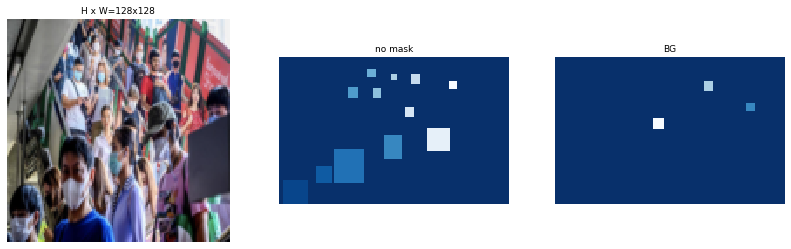

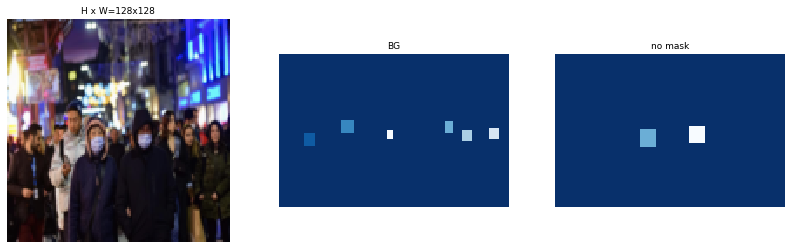

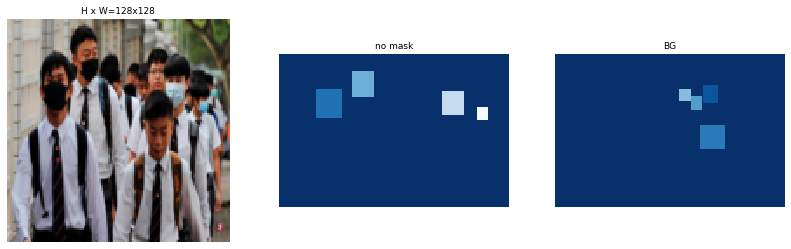

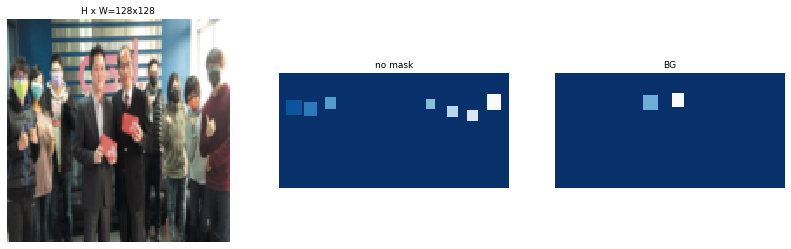

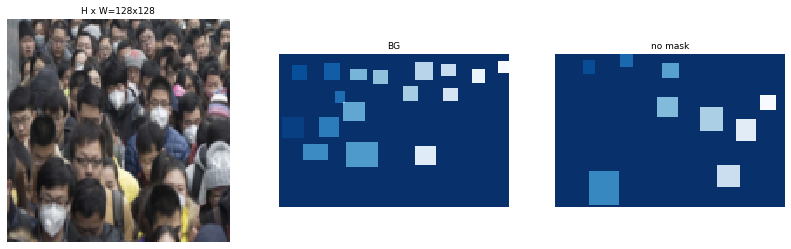

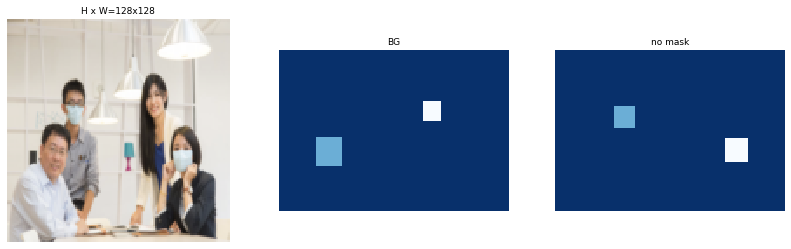

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
print(image_ids)
image_ids = [560, 571, 132, 165, 111, 97]
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, 2)

## Create Model

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

In [8]:
# Which weights to start with?
init_with = "imagenet"  #"coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH) #, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

Using TensorFlow backend.


## Training

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_valid, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /Users/rebeccayu/Files/cs/601.475_ml/475Project/logs/faces20201214T1653/mask_rcnn_faces_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (Tim

W1214 16:54:48.765691 4521139712 summary_ops_v2.py:1110] Model failed to serialize as JSON. Ignoring... Layers with arguments in `__init__` must override `get_config`.
/Users/rebeccayu/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/rebeccayu/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/rebeccayu/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may con

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_valid, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

## Detection

In [6]:
class InferenceConfig(FacesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

W1214 18:17:23.144036 4370292224 deprecation.py:506] From /Users/rebeccayu/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Loading weights from  /Users/rebeccayu/Files/cs/601.475_ml/475Project/logs/faces20201214T1657/mask_rcnn_faces_0002.h5
Re-starting from epoch 2


In [7]:
visualize.display_weight_stats(model)

WEIGHT NAME,SHAPE,MIN,MAX,STD
conv1/kernel:0,"(7, 7, 3, 64)",-0.6713,+0.7045,+0.1111
conv1/bias:0,"(64,)",-0.0003,+0.0002,+0.0001
bn_conv1/gamma:0,"(64,)",+0.5123,+2.6684,+0.4650
bn_conv1/beta:0,"(64,)",-2.6542,+6.3502,+1.8954
bn_conv1/moving_mean:0,"(64,)",-3.5374,+3.3343,+1.0033
bn_conv1/moving_variance:0*** Overflow?,"(64,)",+184.1078,+83614.7344,+13554.5430
res2a_branch2a/kernel:0,"(1, 1, 64, 64)",-0.7170,+0.3921,+0.0714
res2a_branch2a/bias:0,"(64,)",-0.0092,+0.0057,+0.0025
bn2a_branch2a/gamma:0,"(64,)",+0.5132,+2.0699,+0.3734
bn2a_branch2a/beta:0,"(64,)",-2.4112,+3.6054,+1.1678


original_image           shape: (128, 128, 3)         min:    2.00000  max:  255.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max:  128.00000  int64
gt_class_id              shape: (4,)                  min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (4, 4)                min:   67.00000  max:  356.00000  int32
gt_mask                  shape: (56, 56, 4)           min:    1.00000  max:    1.00000  bool


ValueError: operands could not be broadcast together with shapes (56,56) (128,128) (128,128) 

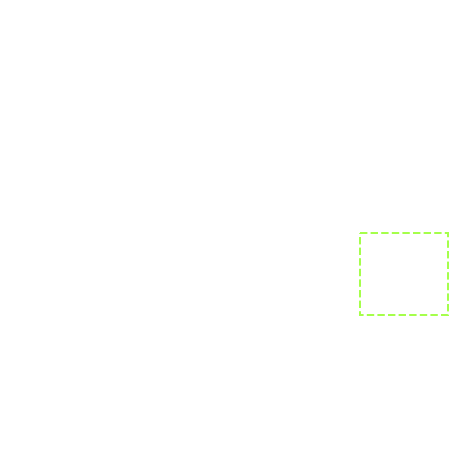

In [16]:
# Test on a random image
image_id = random.choice(dataset_test.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inference_config, image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))